In [1]:
# 分析预测结果的 EI-NA 现象
%reload_ext autoreload
%autoreload 2

import sys
import arrow
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt

sys.path.append('X:/WorkSpace/tensorflow')

from src.config.params import BASE_NINO_DATA_PATH
from src.analysis.SH import analyze_sst_spherical_harmonics, SphericalHarmonicAnalysis
from src.dataset.ERA5 import ERA5SSTMonthlyDataset


The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [2]:

# 读取 NINO 数据

nino12 = nc.Dataset(f"{BASE_NINO_DATA_PATH}/nina1.anom.nc").variables['value'][-240:]
nino3 = nc.Dataset(f"{BASE_NINO_DATA_PATH}/nina3.anom.nc").variables['value'][-240:]
nino34 = nc.Dataset(f"{BASE_NINO_DATA_PATH}/nina34.anom.nc").variables['value'][-240:]
nino4 = nc.Dataset(f"{BASE_NINO_DATA_PATH}/nina4.anom.nc").variables['value'][-240:]

# 读取时间范围
time = nc.Dataset(f"{BASE_NINO_DATA_PATH}/nina1.anom.nc").variables['time'][:]

start = arrow.get('1950-01-01')
end = start.shift(months=len(time))

time_range = arrow.Arrow.span_range('month', start, end)

# 假设每个NINO序列的长度相同，生成时间轴
months = np.arange(len(nino12))

fig = plt.figure(dpi=1200, figsize=(10, 6))
ax = fig.add_subplot(111)

ax.plot(months, nino12, label='NINO1+2')
ax.plot(months, nino3, label='NINO3')
ax.plot(months, nino34, label='NINO3.4')
ax.plot(months, nino4, label='NINO4')

ax.set_title('NINO SSTA')
ax.set_xlabel('Date (month)')
ax.set_ylabel('SSTA (°C)')
ax.legend()
ax.grid(True)


加载ERA5海表温度数据...
起始时间：2004-01-01
Starting spherical harmonic expansion...
Starting spherical harmonic expansion, maximum degree: 5
Reconstructing sea surface temperature data...
Generating visualization plots...
Starting spherical harmonic expansion, maximum degree: 5
阶数 5: RMSE = 6.3540°C


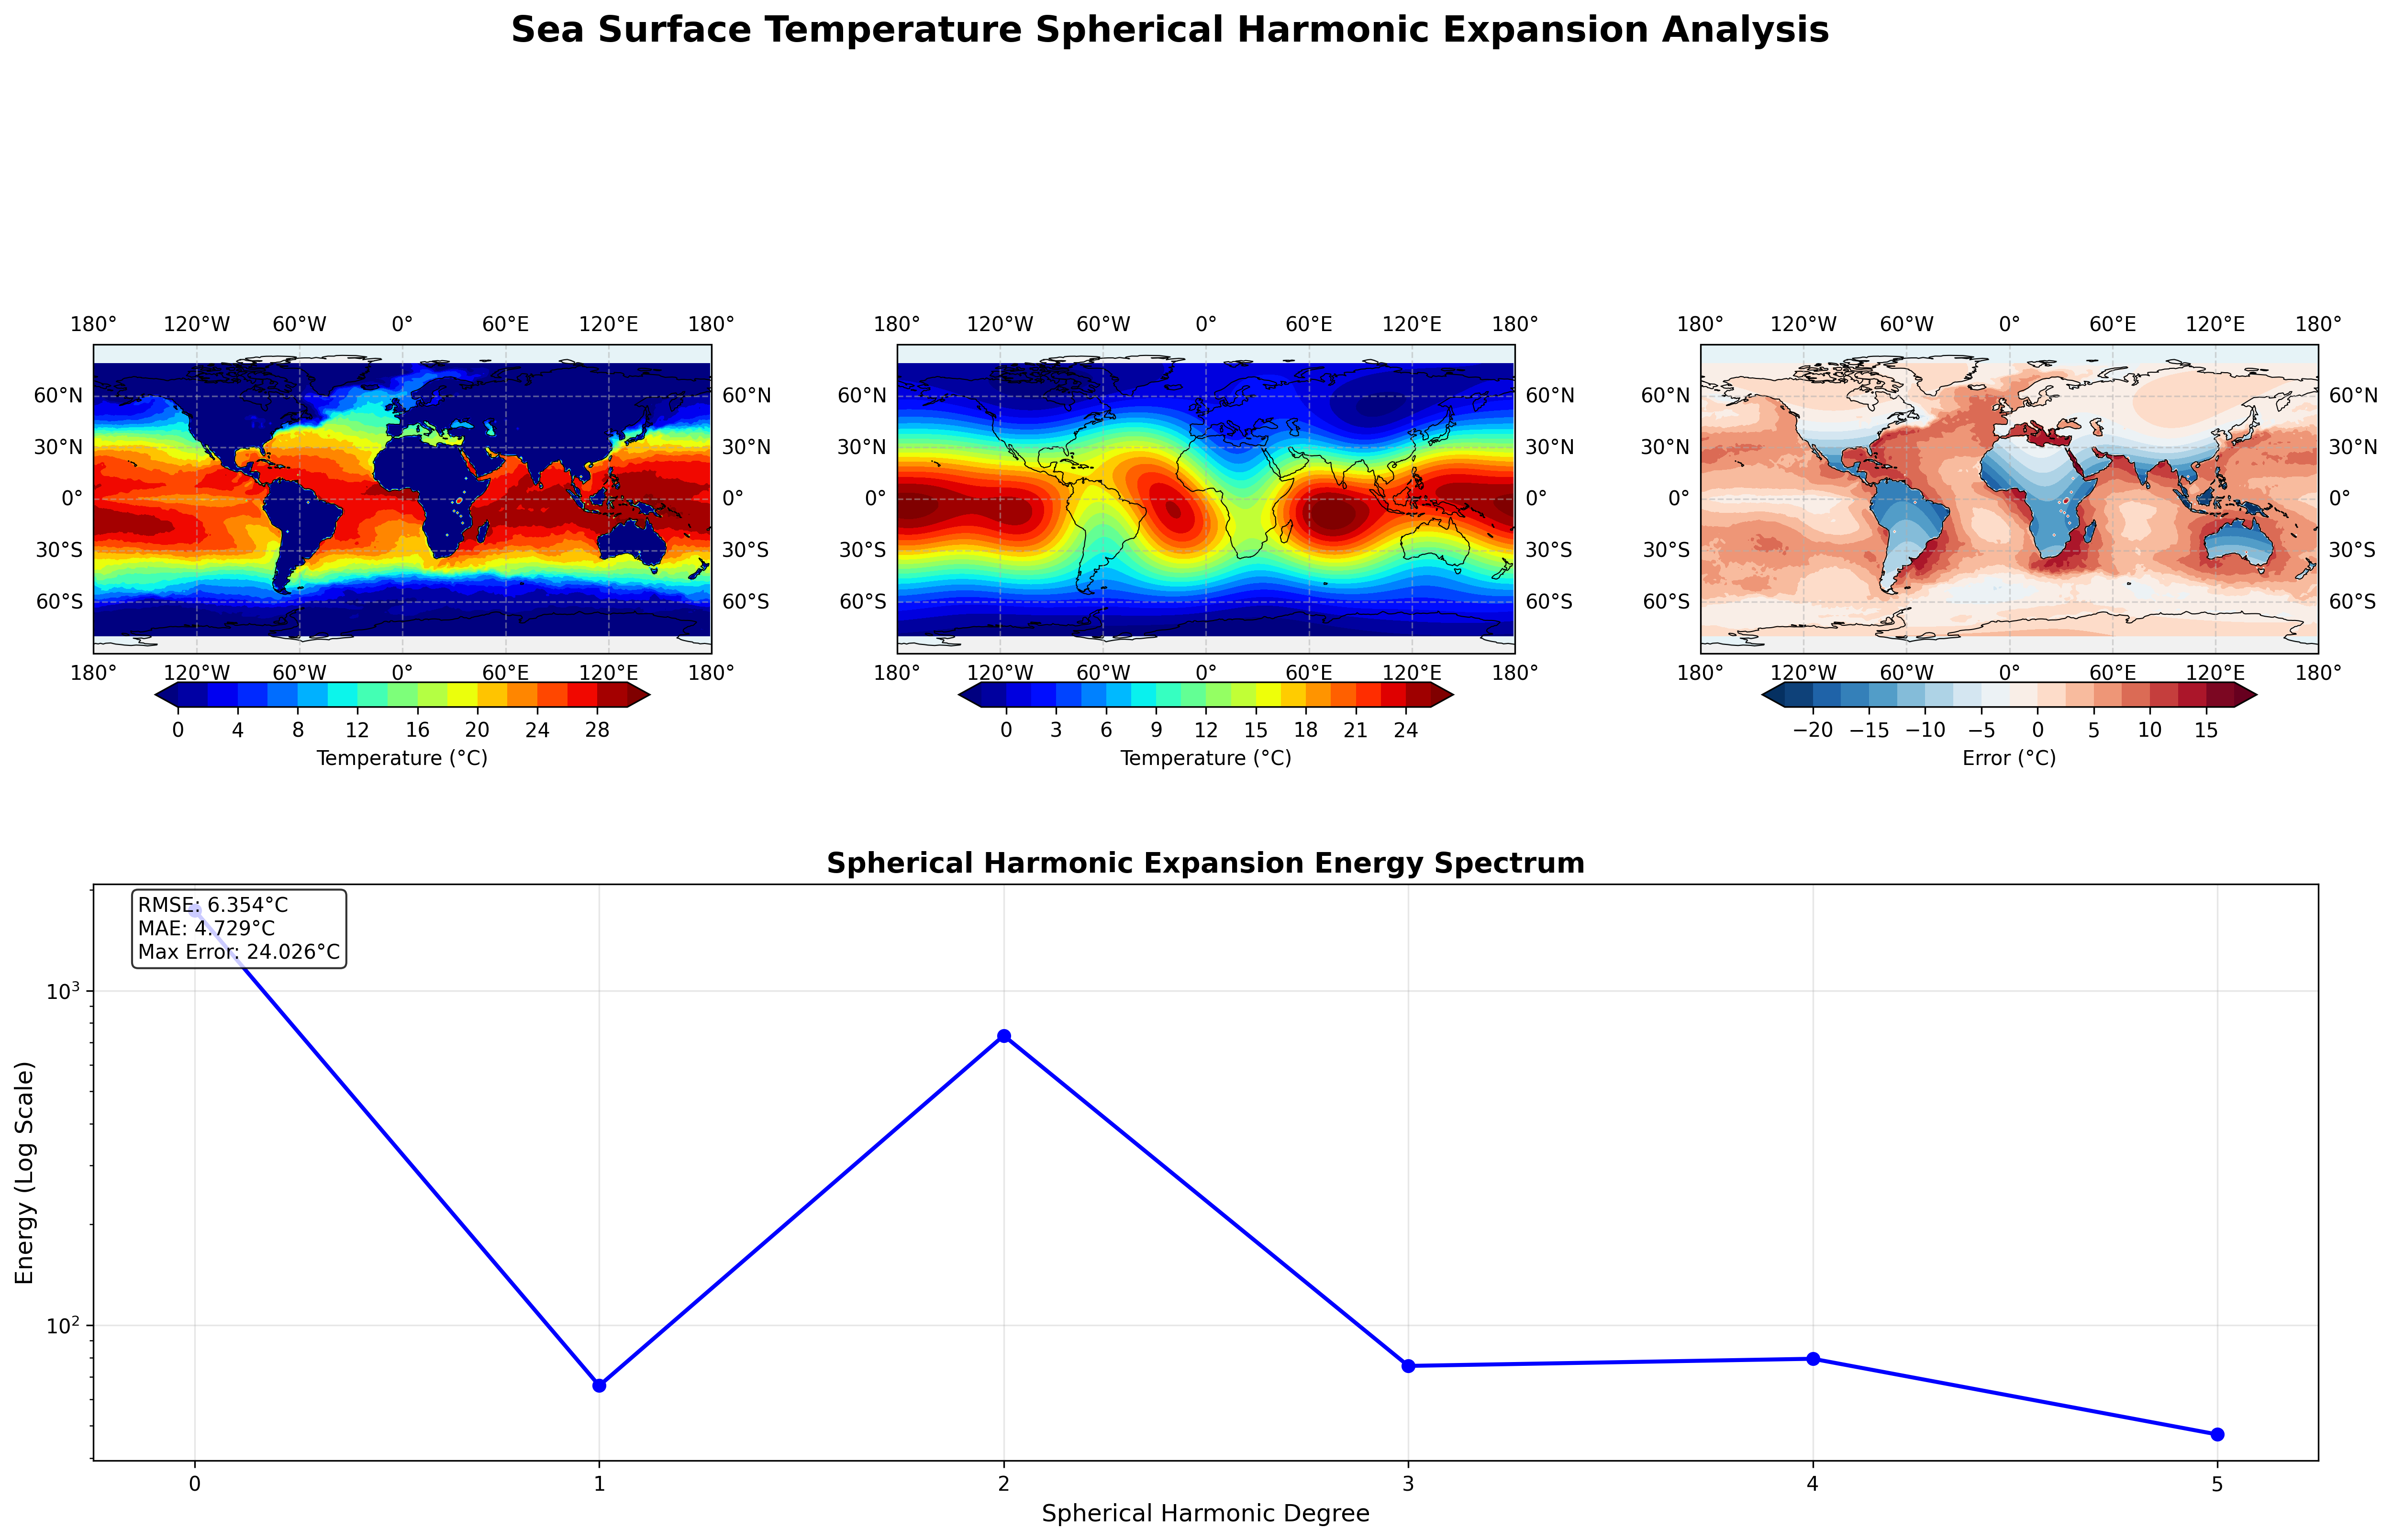

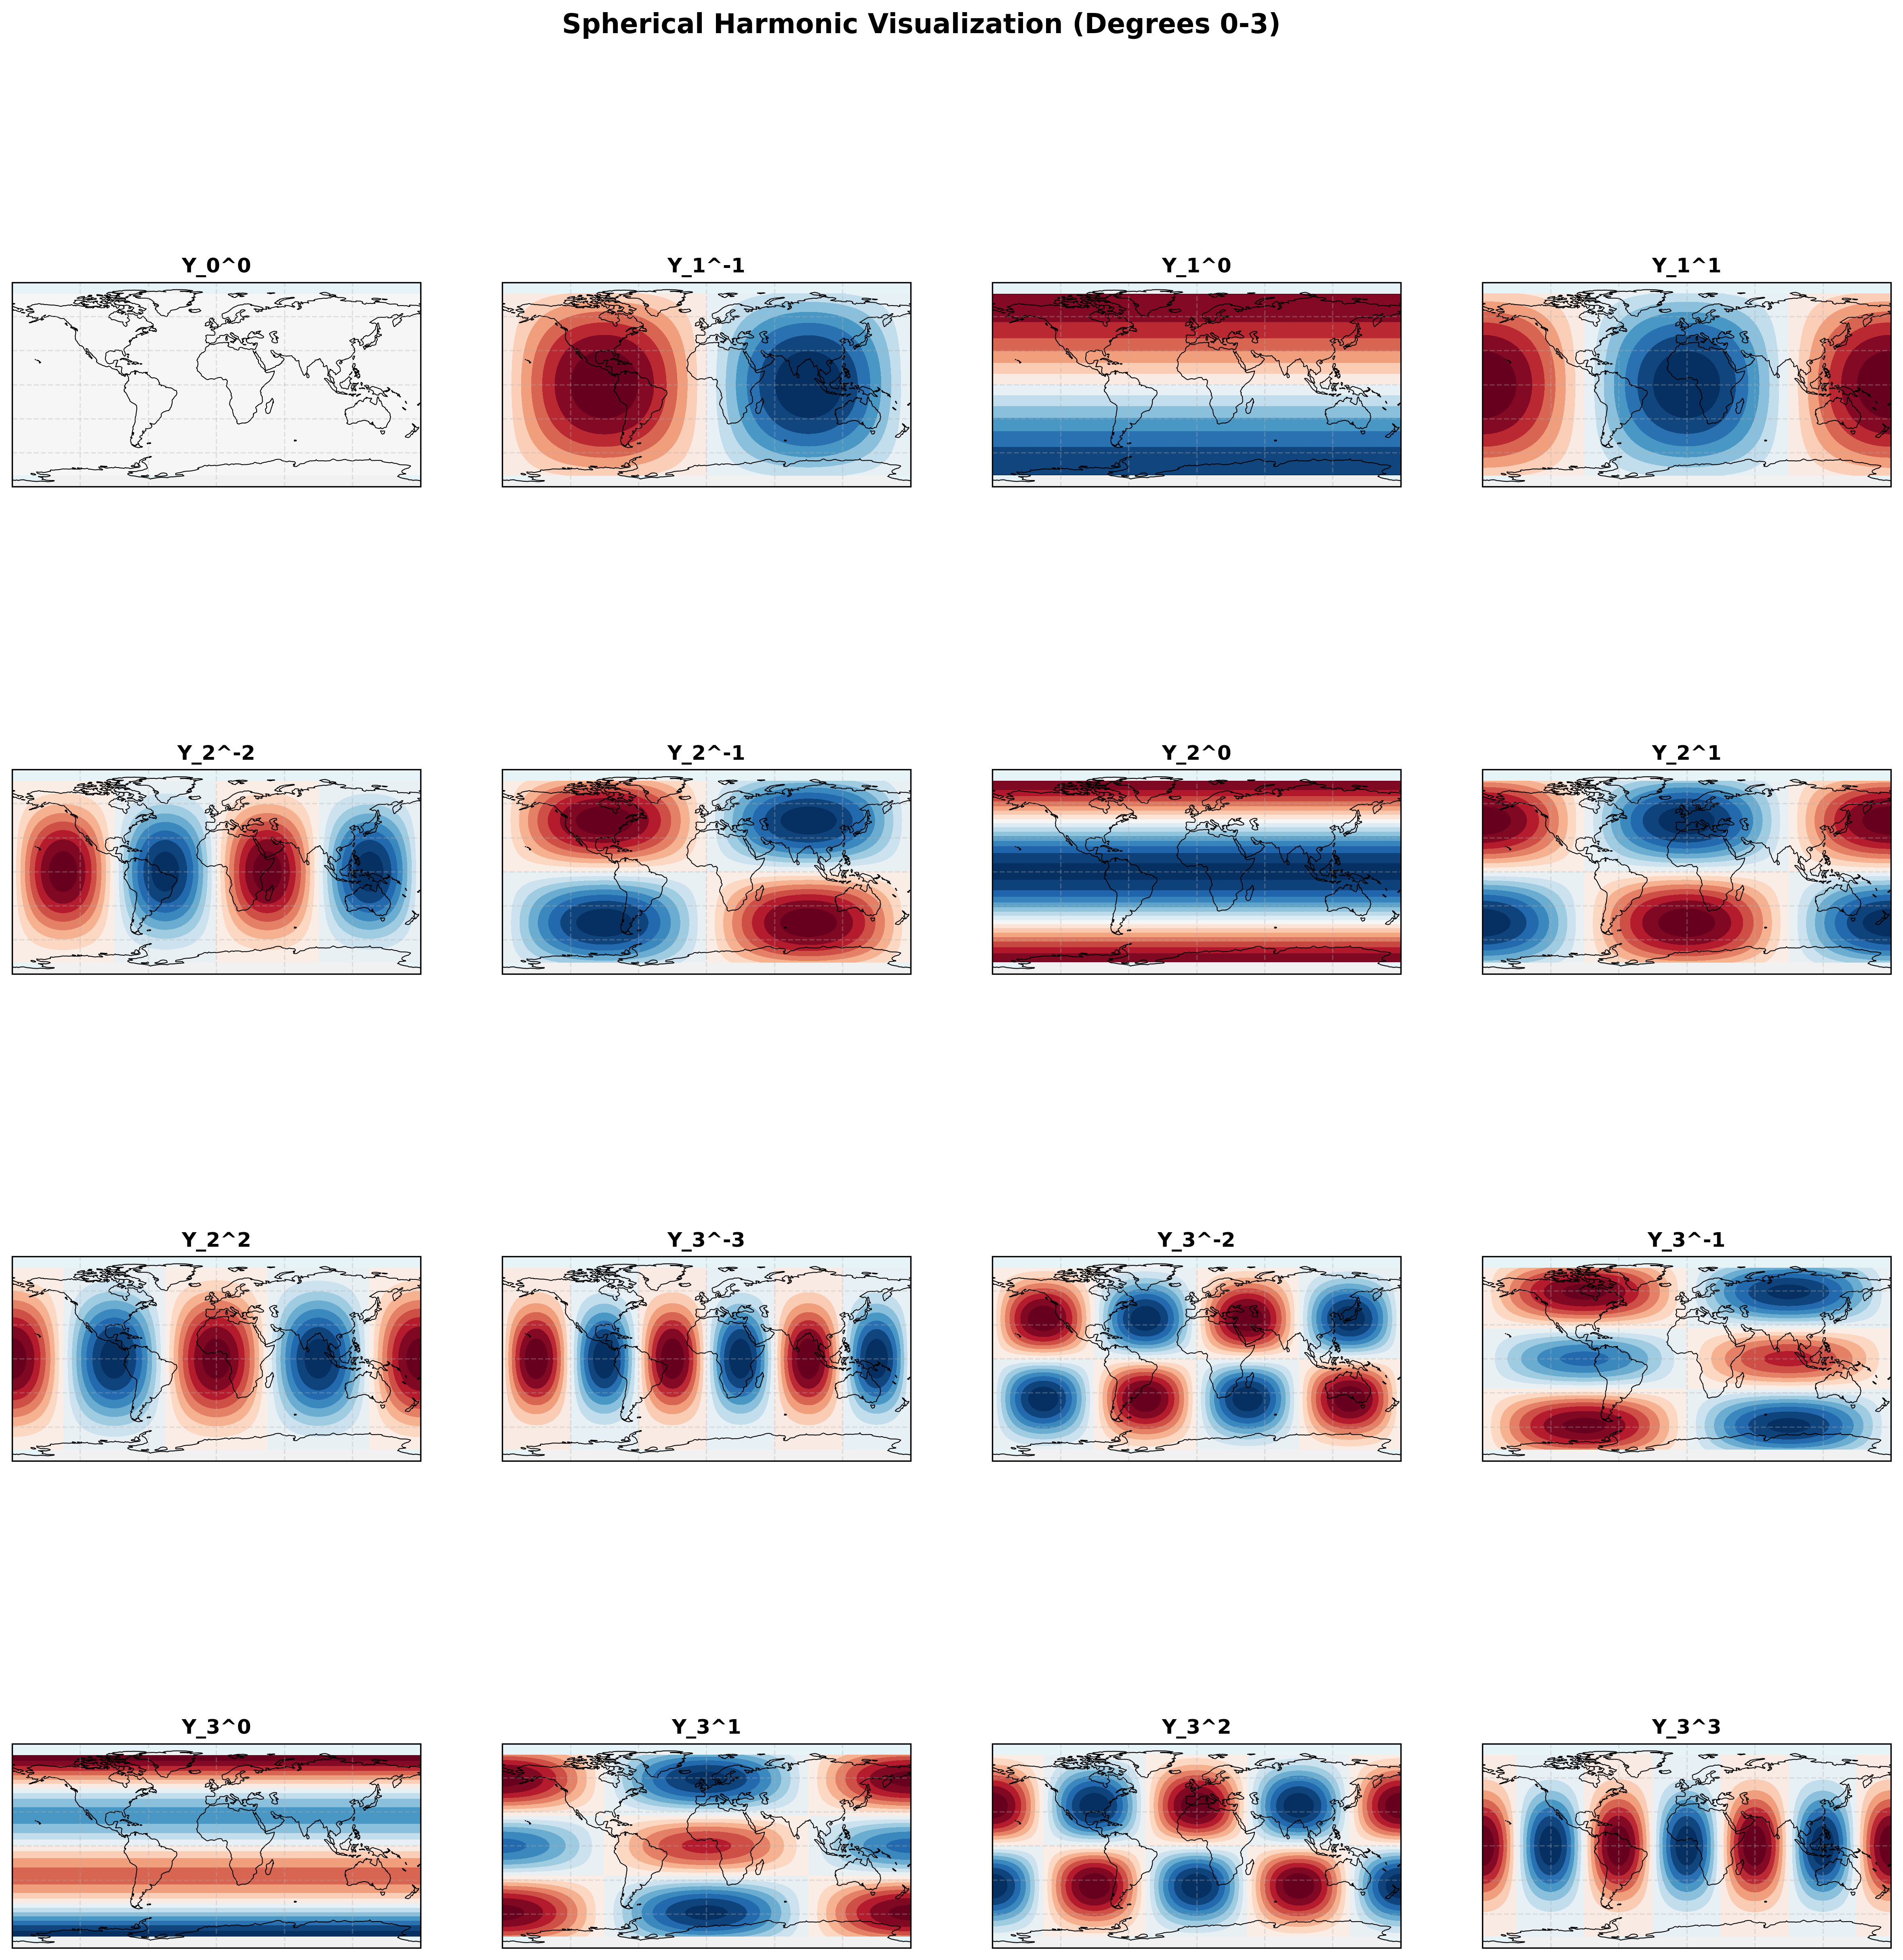

In [5]:
print("加载ERA5海表温度数据...")
    
# 加载ERA5数据集
dataset = ERA5SSTMonthlyDataset(2, 0, lon=[-180, 180], lat=[-80, 80], resolution=1)

# 获取一个月的数据作为示例
sst_data = dataset.__getitem__(240)  # 获取第一个月的数据
if isinstance(sst_data, tuple):
    sst_data = sst_data[0].detach().numpy()

sst_data = sst_data[0,0,:,:]
sst_data[np.isnan(sst_data)] = 0.0

lon = np.arange(-180, 180)  # 经度
lat = np.arange(-80, 80)    # 纬度

degree = 5

# 进行球谐函数展开分析
analyzer, coefficients, reconstructed = analyze_sst_spherical_harmonics(
    sst_data, lon, lat, max_degree=degree
)


# 为每个阶数创建新的分析器
temp_analyzer = SphericalHarmonicAnalysis(max_degree=degree)

try:
    # 重新进行球谐函数展开
    temp_coefficients = temp_analyzer.expand_sst_data(sst_data, lon, lat)
    
    # 重构数据
    recon = temp_analyzer.reconstruct_sst(lon, lat, max_degree=degree)
    
    # 计算RMSE
    sst_np = sst_data
    rmse = np.sqrt(np.mean((sst_np - recon)**2))
    print(f"阶数 {degree}: RMSE = {rmse:.4f}°C")
    
except Exception as e:
    print(f"阶数 {degree} 重构失败: {e}")